# Tutorial 04

## partial-sky ABS pipeline (with noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

Measurement uncertainties are prepared as white noise.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 20  # size of resampling
APOSCALE = 6.
PSBIN = 3
LMIN = 30
LMAX = 200

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = np.zeros((NSAMP,3,12*NSIDE**2),dtype=np.float32)
for i in range(NSAMP):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
    
fidmap = dict()
fidmap[23] = mapcmb
fidmap[95] = mapcmb
fidmap[150] = mapcmb
fidmap[353] = mapcmb

databeam = dict()
databeam[23] = (52.8/60.)*np.pi/180.
databeam[95] = (19./60.)*np.pi/180.
databeam[150] = (11./60.)*np.pi/180.
databeam[353] = (4.94/60.)*np.pi/180.

datamap = dict()
datamap[23] = hp.smoothing(mapcmb[0],fwhm=databeam[23],verbose=0) + nmap23[0]
datamap[95] = hp.smoothing(mapcmb[0],fwhm=databeam[95],verbose=0) + nmap95[0]
datamap[150] = hp.smoothing(mapcmb[0],fwhm=databeam[150],verbose=0) + nmap150[0]
datamap[353] = hp.smoothing(mapcmb[0],fwhm=databeam[353],verbose=0) + nmap353[0]

datanoise = dict()
datanoise[23] = nmap23[1:]
datanoise[95] = nmap95[1:]
datanoise[150] = nmap150[1:]
datanoise[353] = nmap353[1:]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
est.targets = ('TT',)
cmb_dl_t = est.autoBP(mapcmb[0])
est.targets = ('EE','BB')
cmb_dl_eb = est.autoBP(mapcmb[0])
cmb_dl = np.vstack([cmb_dl_t[1],cmb_dl_eb[1],cmb_dl_eb[2]])

#### run ABS pipeline

CPU times: user 3h 18min 11s, sys: 2.95 s, total: 3h 18min 14s
Wall time: 25min 3s


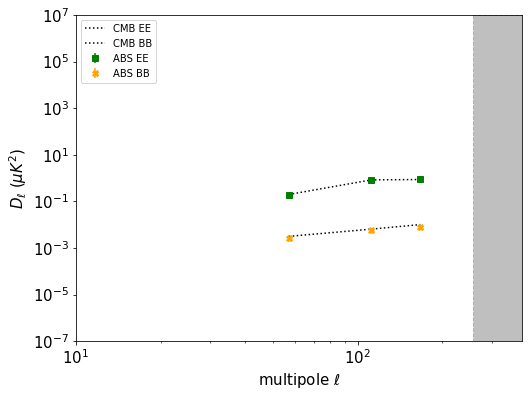

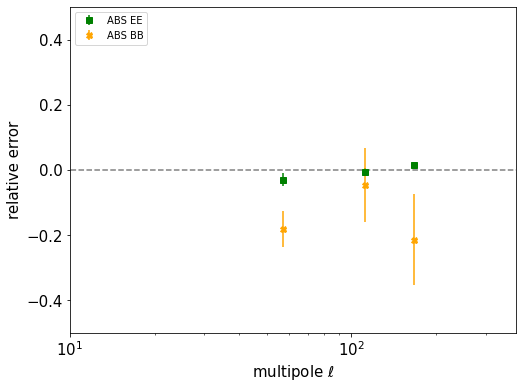

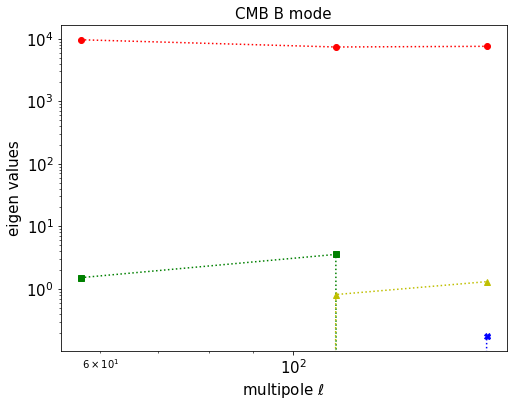

In [2]:
%%time

pp = af.abspipe(datamap,mask=mask,noises=datanoise,beams=databeam,targets=('EE','BB'),
                fiducials=fidmap,background='acmb')
modes, rslt_eb, info_eb = pp.run_absonly(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                                         shift=10.,threshold=1.)

rslt_eb_mean = np.mean(rslt_eb,axis=0)
rslt_eb_std = np.std(rslt_eb,axis=0)

fig,ax = plt.subplots(figsize=(8,6))

ax.plot(modes,cmb_dl[1],color='black',linestyle=':',label=r'CMB EE')
ax.plot(modes,cmb_dl[2],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(modes,rslt_eb_mean[0],yerr=rslt_eb_std[0],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(modes,rslt_eb_mean[1],yerr=rslt_eb_std[1],
            color='orange',fmt='X',label=r'ABS BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(8,6))

ax.errorbar(modes,(rslt_eb_mean[0]-cmb_dl[1])/cmb_dl[1],yerr=rslt_eb_std[0]/cmb_dl[1],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(modes,(rslt_eb_mean[1]-cmb_dl[2])/cmb_dl[2],yerr=rslt_eb_std[1]/cmb_dl[2],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))


fig,ax = plt.subplots(figsize=(8,6))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(modes)))
for i in range(eigens.shape[1]):
    eigens[:,i] = info_eb['BB'][i][0] 
ax.plot(modes,eigens[0],linestyle=':',color='r',marker='o')
ax.plot(modes,eigens[1],linestyle=':',color='g',marker='s')
ax.plot(modes,eigens[2],linestyle=':',color='b',marker='X')
ax.plot(modes,eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

#### preprocess visualization

In [3]:
print ('data BP:',pp.data_bp.shape)
print ('fiducial BP:',pp.fiducial_bp.shape)
print ('noise BP:',pp.noise_bp.shape)

data BP: (2, 3, 4, 4)
fiducial BP: (20, 2, 3, 4, 4)
noise BP: (20, 2, 3, 4, 4)


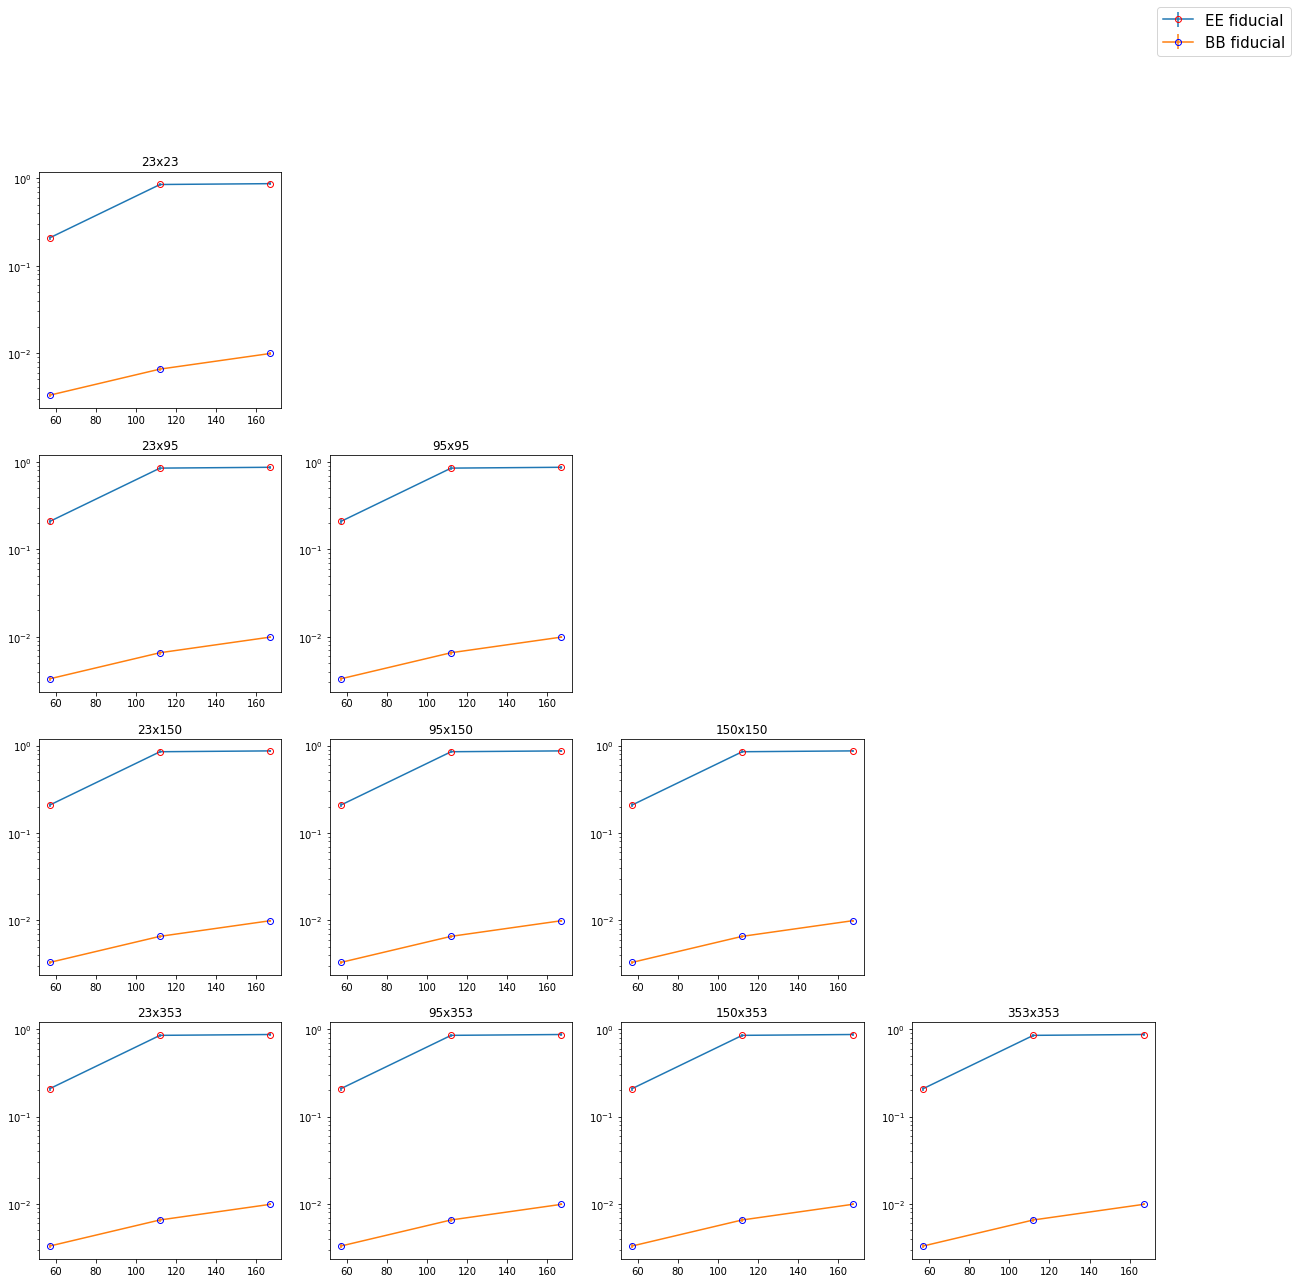

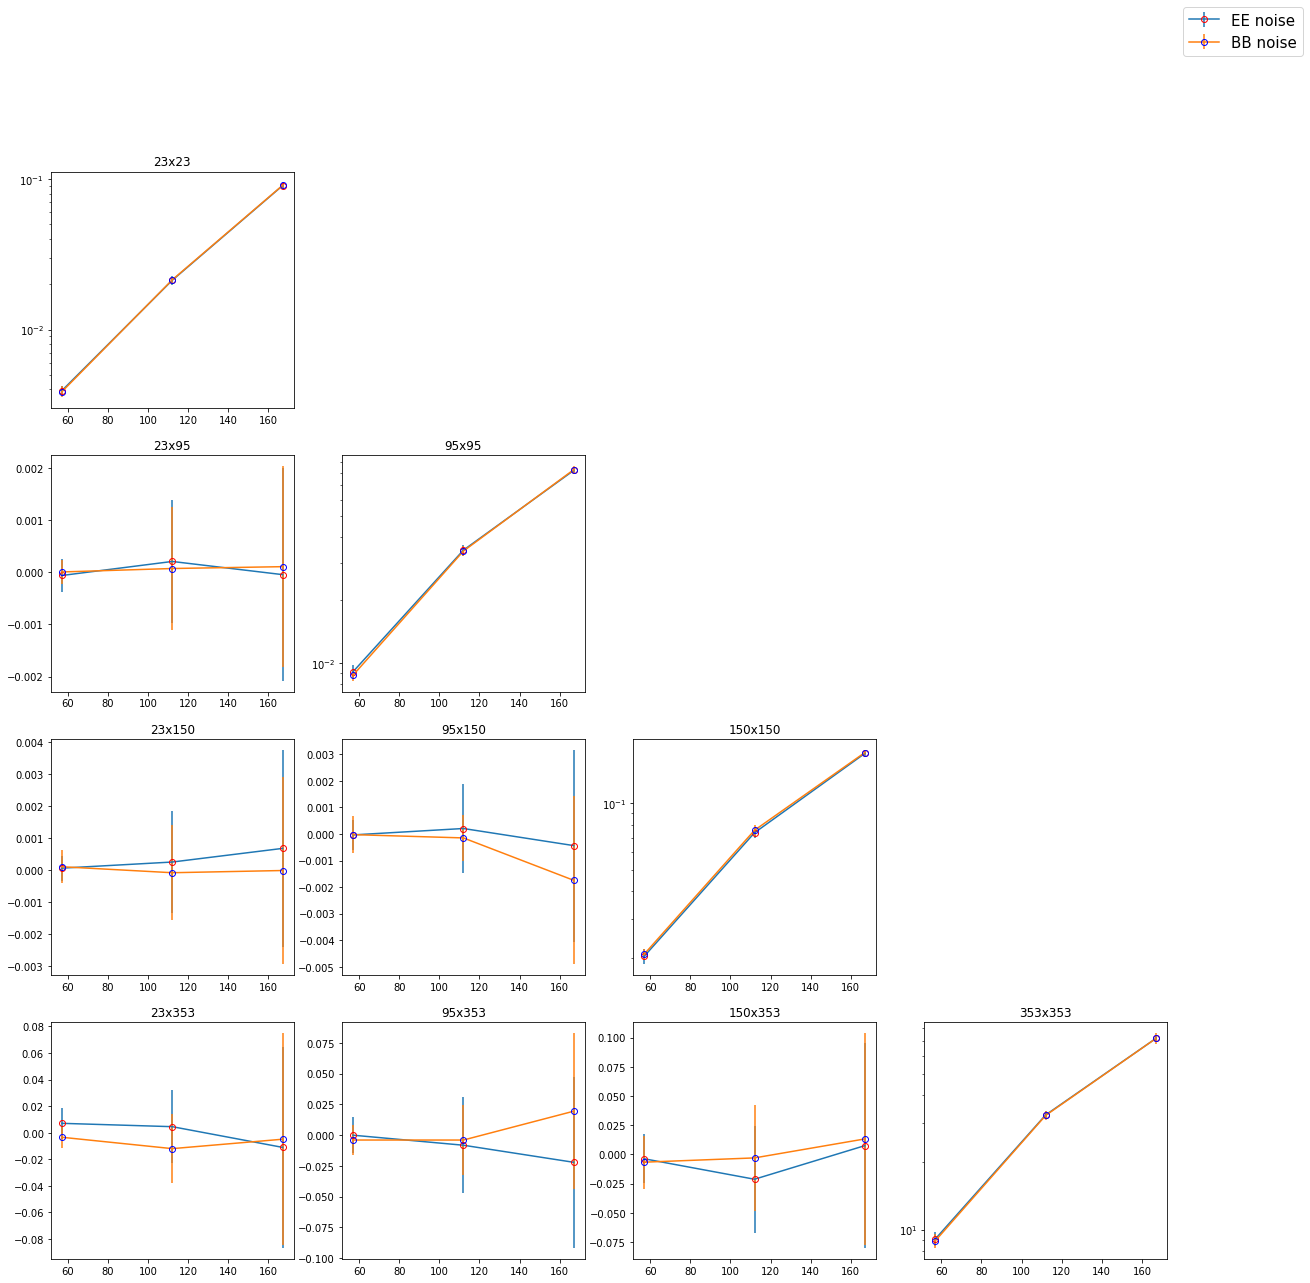

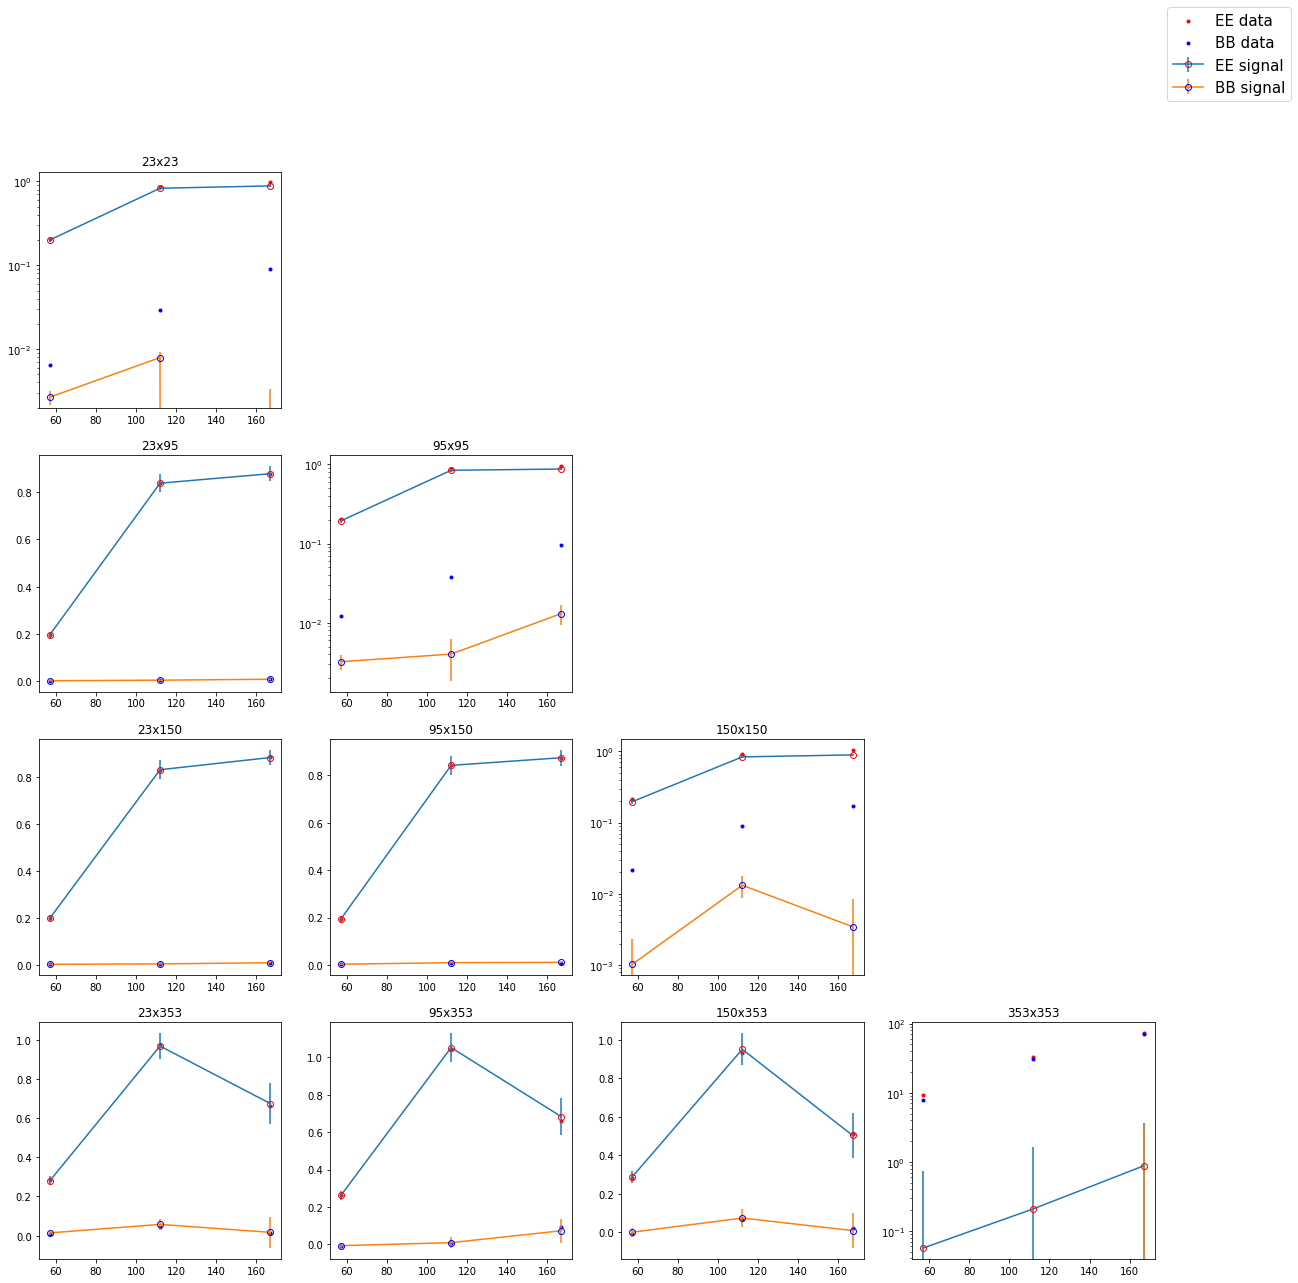

In [4]:
from afra.tools.bp_vis import bpvis
p = bpvis(('EE','BB'),modes,[23,95,150,353],pp.data_bp,pp.fiducial_bp,pp.noise_bp)

#### post-analysis with Minuit

In [5]:
pp.solver = 'minuit'
pp.likelihood = 'gauss'
rslt_g = pp.postprocess()
pp.likelihood = 'hl'
rslt_h = pp.postprocess()
print ('Gauss-likelihood\n best-fit: {}\n std {}'.format(rslt_g[0],rslt_g[1]))
print ('HL-likelihood\n best-fit: {}\n std {}'.format(rslt_h[0],rslt_h[1]))

Gauss-likelihood
 best-fit: [0.98431613 0.87190768 0.03737568]
 std [0.02964513 0.24173056 0.00959681]
HL-likelihood
 best-fit: [0.98324843 0.88770771 0.03689288]
 std [0.02929811 0.22706655 0.00854047]


#### post-analysis wiht dynesty DynamicNestedSampler

23519it [12:34, 31.17it/s, batch: 10 | bound: 62 | nc: 3 | ncall: 58140 | eff(%): 40.452 | loglstar: -9.021 < -1.003 < -1.287 | logz: -9.738 +/-  0.164 | stop:  0.931]               
22184it [15:36, 23.68it/s, batch: 10 | bound: 63 | nc: 1 | ncall: 62317 | eff(%): 35.599 | loglstar: -8.782 < -1.247 < -1.777 | logz: -10.025 +/-  0.166 | stop:  0.931]            


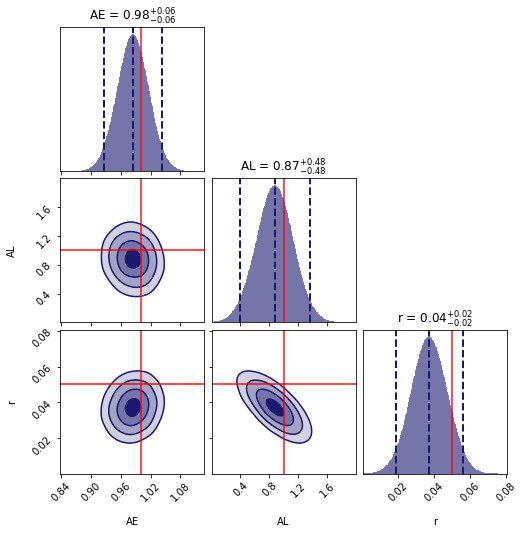

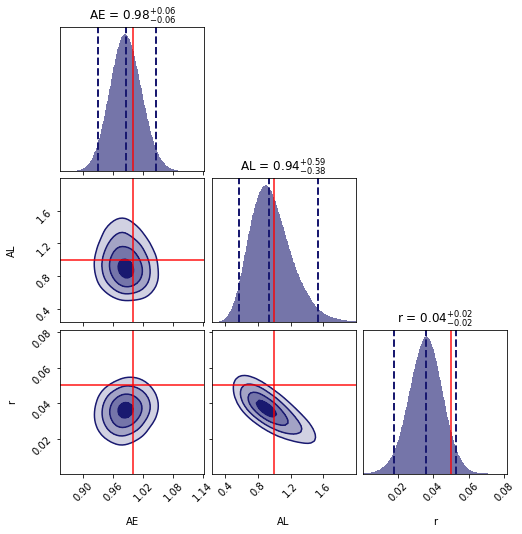

In [6]:
pp.solver = 'dynesty'
pp.likelihood = 'gauss'
rslt_g = pp.postprocess()
pp.likelihood = 'hl'
rslt_h = pp.postprocess()

fg,ax = dyplot.cornerplot(rslt_g,labels=pp.paramlist,truths=[1.,1.,0.05],
                          color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg,ax = dyplot.cornerplot(rslt_h,labels=pp.paramlist,truths=[1.,1.,0.05],
                          color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

end